In [4]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [5]:
# Import Dataset
all_data = pd.read_excel("../data/CustomerChurn.xlsx")
# Remove the customer ID labels
all_data.drop(["LoyaltyID", "Customer ID"], axis = 1, inplace = True)
# Display the data
all_data.head()

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Senior Citizen     7043 non-null   object 
 1   Partner            7043 non-null   object 
 2   Dependents         7043 non-null   object 
 3   Tenure             7043 non-null   int64  
 4   Phone Service      7043 non-null   object 
 5   Multiple Lines     7043 non-null   object 
 6   Internet Service   7043 non-null   object 
 7   Online Security    7043 non-null   object 
 8   Online Backup      7043 non-null   object 
 9   Device Protection  7043 non-null   object 
 10  Tech Support       7043 non-null   object 
 11  Streaming TV       7043 non-null   object 
 12  Streaming Movies   7043 non-null   object 
 13  Contract           7043 non-null   object 
 14  Paperless Billing  7043 non-null   object 
 15  Payment Method     7043 non-null   object 
 16  Monthly Charges    7043 

In [7]:
sum(all_data["Total Charges"] == ' ')

11

In [8]:
all_data[all_data["Total Charges"] == " "]

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
488,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


There's 11 of the above... let's just get rid of them.

In [9]:
all_data.drop(all_data[all_data["Total Charges"] == " "].index, inplace = True)
all_data.reset_index(drop = True, inplace = True)
sum(all_data["Total Charges"] == ' ')

0

In [10]:
all_data["Total Charges"] = all_data["Total Charges"].astype(float)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Senior Citizen     7032 non-null   object 
 1   Partner            7032 non-null   object 
 2   Dependents         7032 non-null   object 
 3   Tenure             7032 non-null   int64  
 4   Phone Service      7032 non-null   object 
 5   Multiple Lines     7032 non-null   object 
 6   Internet Service   7032 non-null   object 
 7   Online Security    7032 non-null   object 
 8   Online Backup      7032 non-null   object 
 9   Device Protection  7032 non-null   object 
 10  Tech Support       7032 non-null   object 
 11  Streaming TV       7032 non-null   object 
 12  Streaming Movies   7032 non-null   object 
 13  Contract           7032 non-null   object 
 14  Paperless Billing  7032 non-null   object 
 15  Payment Method     7032 non-null   object 
 16  Monthly Charges    7032 

In [11]:
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        print("------------")
        print(col)
        print(all_data[col].unique())

------------
Senior Citizen
['No' 'Yes']
------------
Partner
['Yes' 'No']
------------
Dependents
['No' 'Yes']
------------
Phone Service
['No' 'Yes']
------------
Multiple Lines
['No phone service' 'No' 'Yes']
------------
Internet Service
['DSL' 'Fiber optic' 'No']
------------
Online Security
['No' 'Yes' 'No internet service']
------------
Online Backup
['Yes' 'No' 'No internet service']
------------
Device Protection
['No' 'Yes' 'No internet service']
------------
Tech Support
['No' 'Yes' 'No internet service']
------------
Streaming TV
['No' 'Yes' 'No internet service']
------------
Streaming Movies
['No' 'Yes' 'No internet service']
------------
Contract
['Month-to-month' 'One year' 'Two year']
------------
Paperless Billing
['Yes' 'No']
------------
Payment Method
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
------------
Churn
['No' 'Yes']


The values "No internet service" and "No phone service" in certain columns are because of a respective value in another column within the same dataset. These values do not need to be represented. However, the columns that they are in are otherwise Yes/No columns that can be turned into binary. These values can be removed by turning them into "No".

In [12]:
# Remove the impresent phrases within the dataframe
all_data = all_data.replace(["No internet service", "No phone service"], "No")

In [13]:
# Before proceeding, we need to turn all the object values into int
for col in all_data.columns:
    # We can start by changing Yes/No into True/False
    if all_data[col].nunique() == 2:
        all_data[col] = all_data[col].replace({'Yes': True, 'No': False})
    

C:\Users\manub\AppData\Local\Temp\ipykernel_22608\999685621.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_data[col] = all_data[col].replace({'Yes': True, 'No': False})


In [14]:
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        print("------------")
        print(col)
        print(all_data[col].unique())

------------
Internet Service
['DSL' 'Fiber optic' 'No']
------------
Contract
['Month-to-month' 'One year' 'Two year']
------------
Payment Method
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [15]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Senior Citizen     7032 non-null   bool   
 1   Partner            7032 non-null   bool   
 2   Dependents         7032 non-null   bool   
 3   Tenure             7032 non-null   int64  
 4   Phone Service      7032 non-null   bool   
 5   Multiple Lines     7032 non-null   bool   
 6   Internet Service   7032 non-null   object 
 7   Online Security    7032 non-null   bool   
 8   Online Backup      7032 non-null   bool   
 9   Device Protection  7032 non-null   bool   
 10  Tech Support       7032 non-null   bool   
 11  Streaming TV       7032 non-null   bool   
 12  Streaming Movies   7032 non-null   bool   
 13  Contract           7032 non-null   object 
 14  Paperless Billing  7032 non-null   bool   
 15  Payment Method     7032 non-null   object 
 16  Monthly Charges    7032 

The only object columns left are Internet Service, Contract, and Payment Method. These can be one-hot encoded. 

In [16]:
onehotcols = ["Internet Service", "Contract", "Payment Method"]

# Get the dummies of these ones
df = pd.get_dummies(all_data, columns=onehotcols, drop_first=False)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Senior Citizen                            7032 non-null   bool   
 1   Partner                                   7032 non-null   bool   
 2   Dependents                                7032 non-null   bool   
 3   Tenure                                    7032 non-null   int64  
 4   Phone Service                             7032 non-null   bool   
 5   Multiple Lines                            7032 non-null   bool   
 6   Online Security                           7032 non-null   bool   
 7   Online Backup                             7032 non-null   bool   
 8   Device Protection                         7032 non-null   bool   
 9   Tech Support                              7032 non-null   bool   
 10  Streaming TV                        

In [18]:
# Save the data
df.to_csv("../data/bs_eda.csv")

# EDA

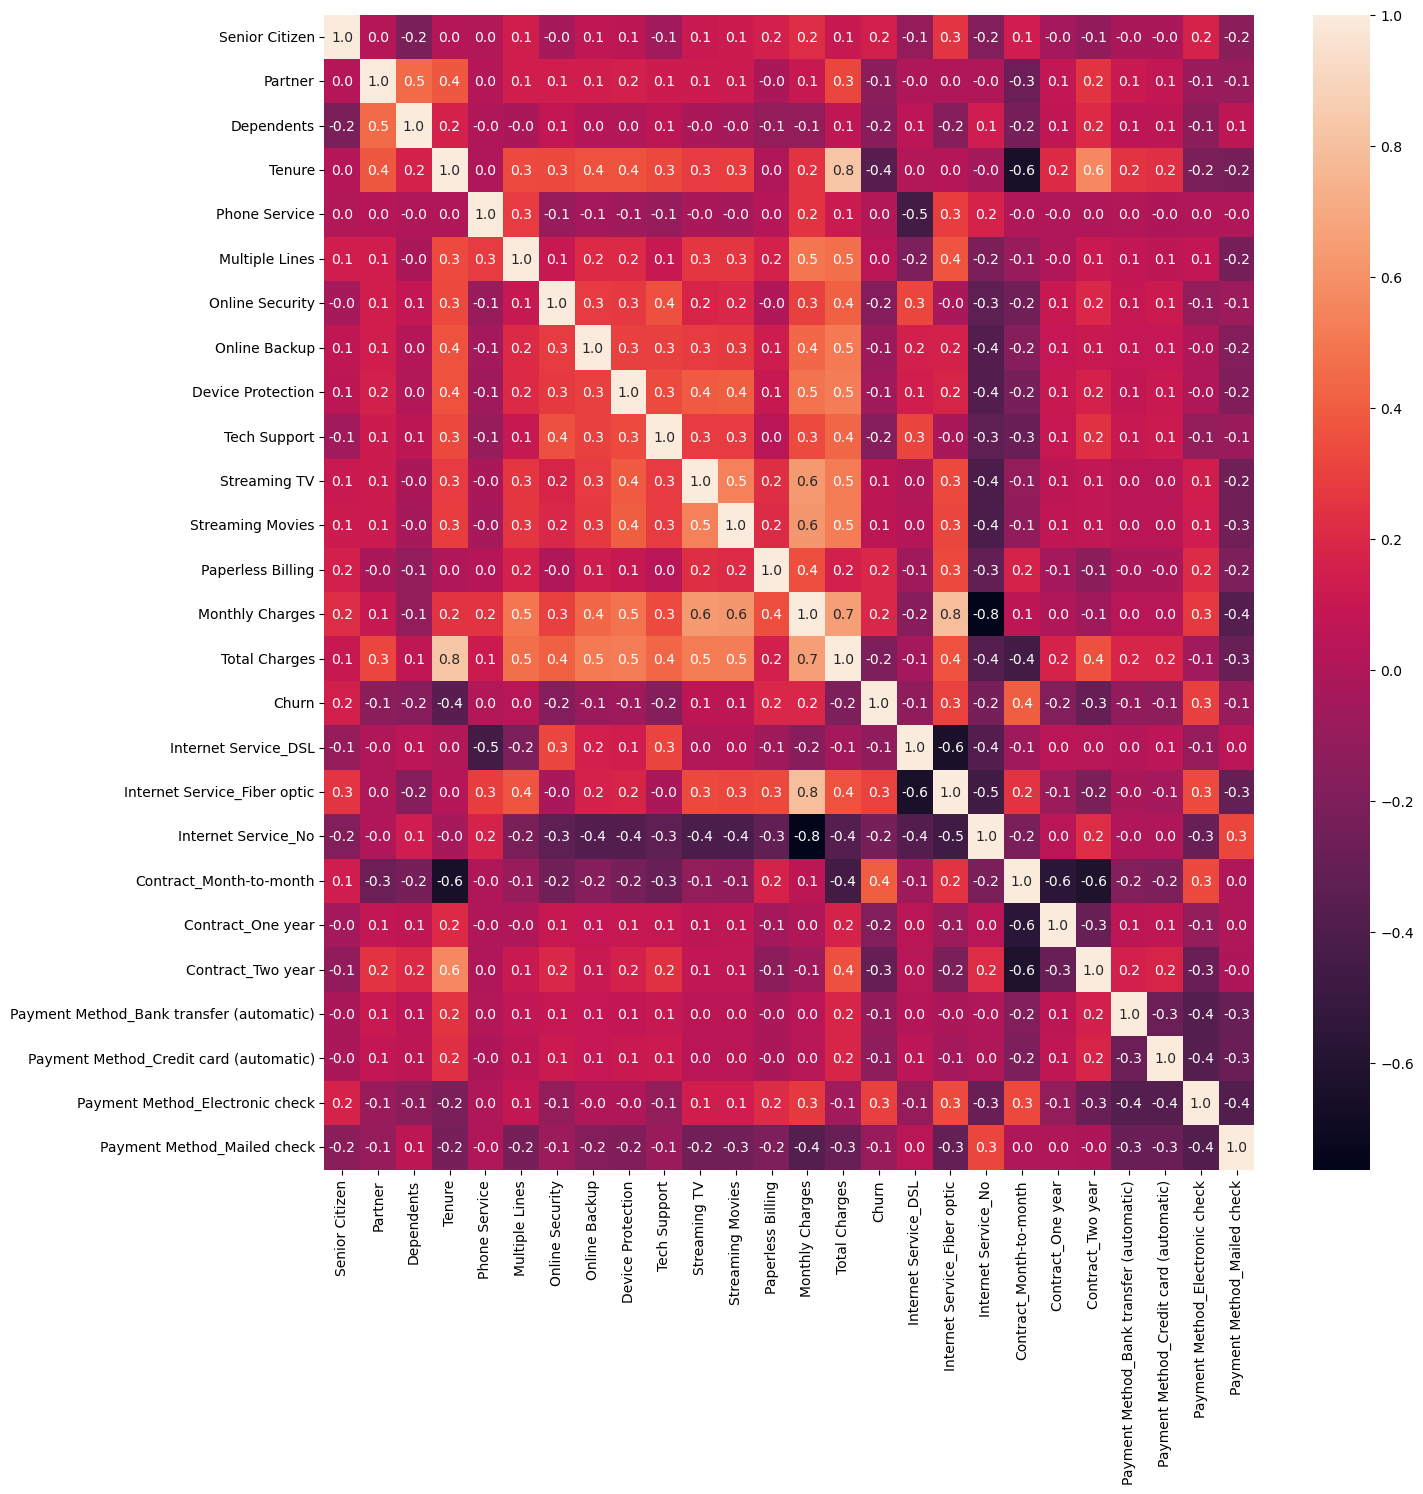

In [15]:
# Create a correlation heatmap
corr_mtx = df.corr()

plt.figure(figsize = (15,15))
sns.heatmap(corr_mtx, annot=True, fmt = ".1f")
plt.show()

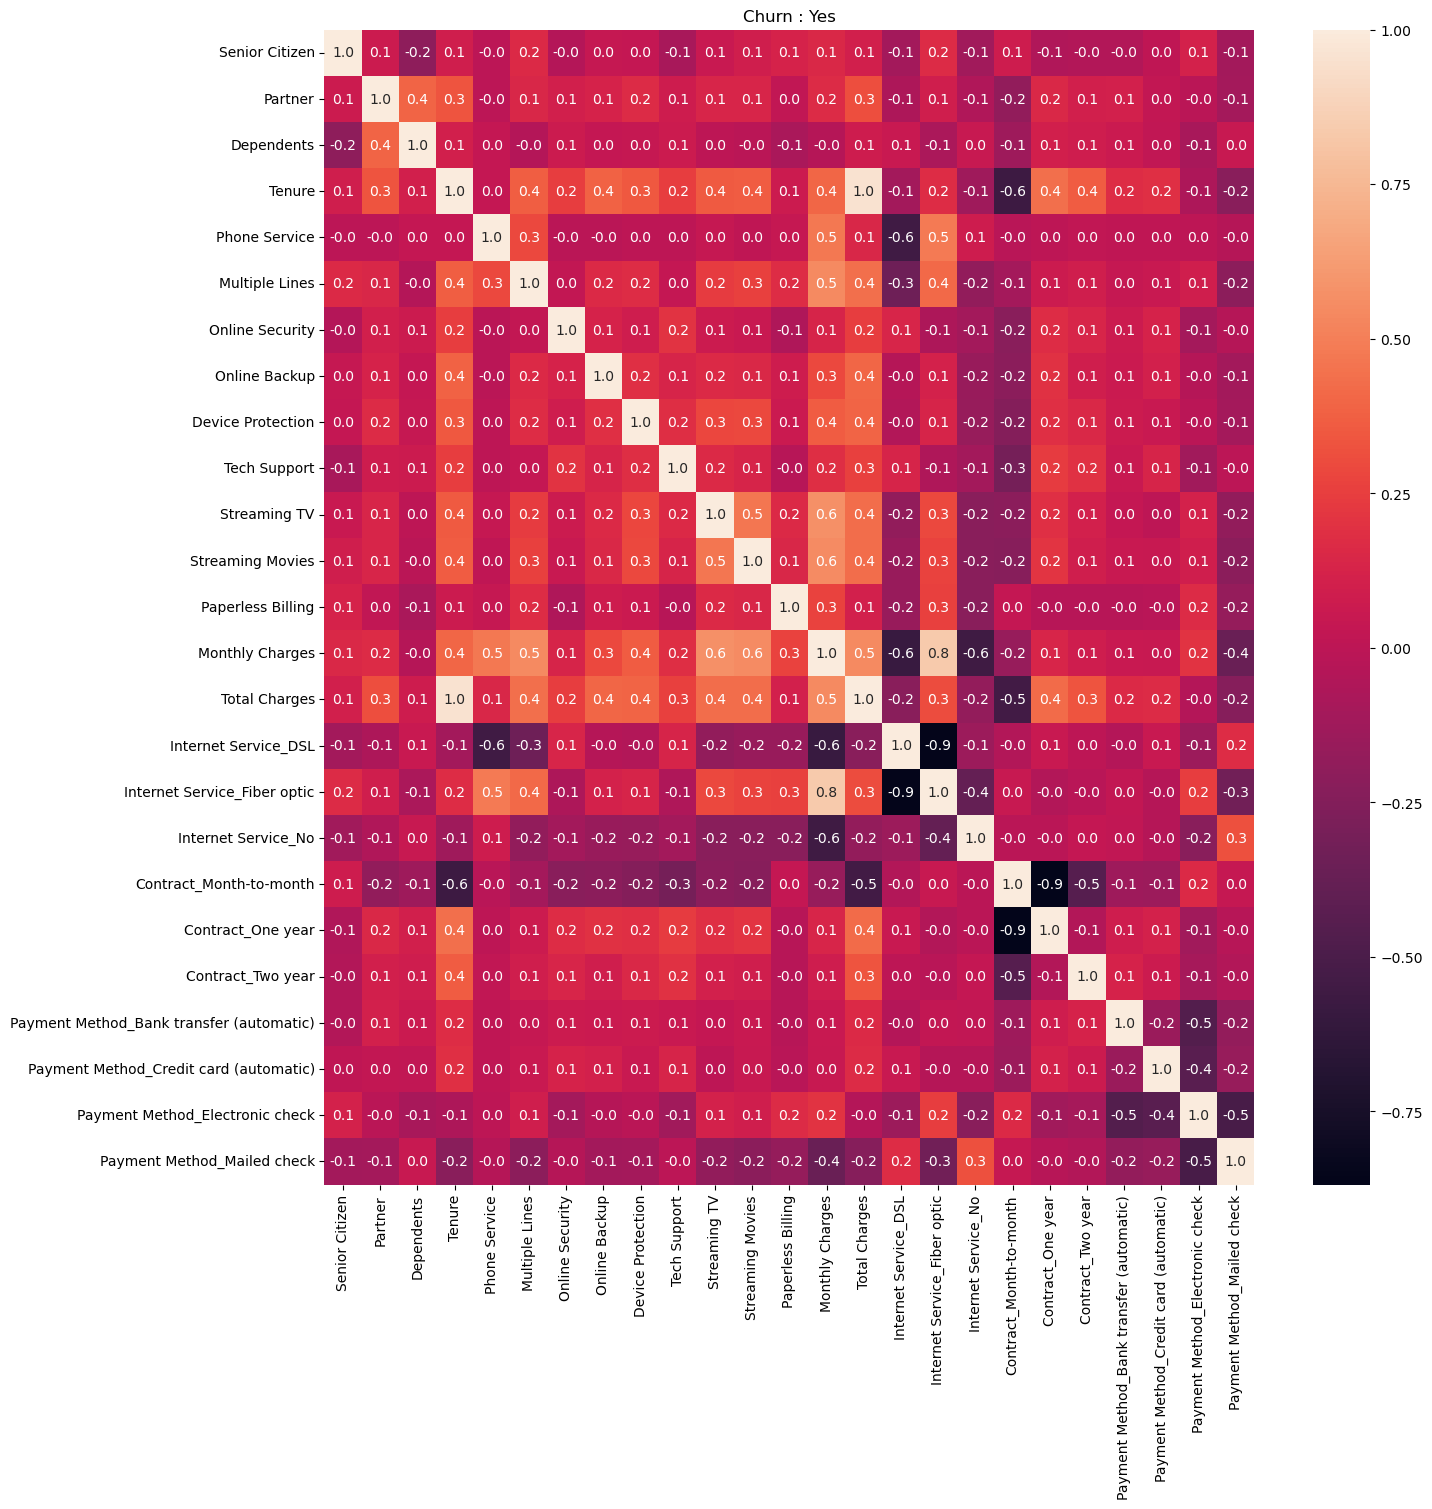

In [16]:
# In addition, create heatmaps for each churn variant.
yeschurn = df[df["Churn"] == True].drop("Churn", axis = 1).corr()
plt.figure(figsize = (15,15))
sns.heatmap(yeschurn, annot=True, fmt = ".1f")
plt.title("Churn : Yes")
plt.show()

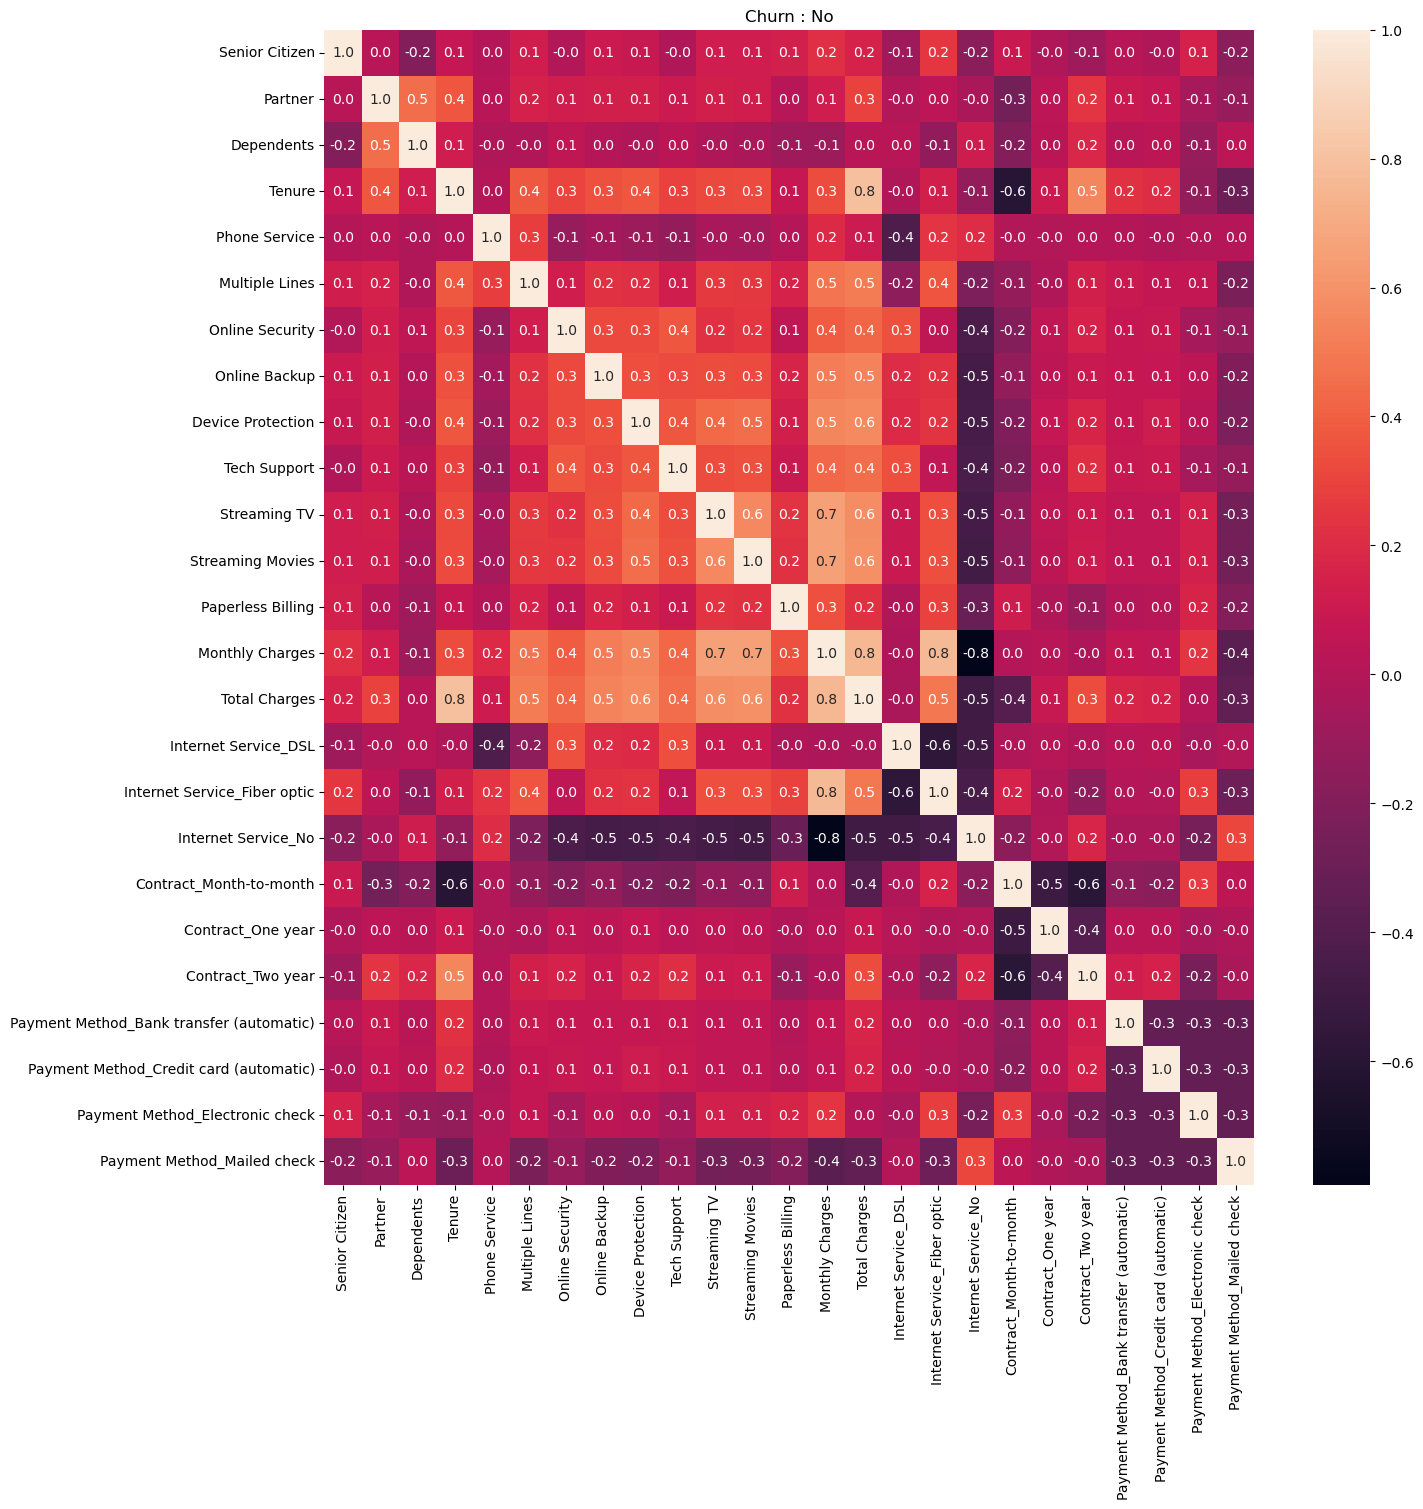

In [17]:
# In addition, create heatmaps for each churn variant.
nochurn = df[df["Churn"] == False].drop("Churn", axis = 1).corr()
plt.figure(figsize = (15,15))
sns.heatmap(nochurn, annot=True, fmt = ".1f")
plt.title("Churn : No")
plt.show()

# Model: SVM
Here I will make the SVM Model

In [20]:
# Split the training data into testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop("Churn", axis = 1), df["Churn"], test_size = 0.2, stratify = df["Churn"])

In [1]:
from thundersvm import *

ModuleNotFoundError: No module named 'thundersvm'

In [21]:
# Create the SVM Model
from thundersvm import SVC
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['poly'],
              'gpu_id': [0]}  
  
grid = GridSearchCV(SVC(), param_grid, cv = 3, scoring = 'accuracy', verbose = 2, n_jobs = -1) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

print("Best cross-validation accuracy: ", grid.best_score_)

FileNotFoundError: Please build the library first!

In [ ]:
from joblib import dump

dump(grid, "svm_model.joblib")

In [21]:
from sklearn.metrics import classification_report

grid_predictions = grid.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

       False       0.81      0.91      0.86      1033
        True       0.63      0.42      0.51       374

    accuracy                           0.78      1407
   macro avg       0.72      0.67      0.68      1407
weighted avg       0.77      0.78      0.77      1407

